## Some ideas for a numerical solution to the SPACE model: Stream Power with Alluvium Conservation and Entrainment
Running a time loop, seeing if things are realistic.
Basic equation set so far, for 1D. Sediment flux downstream:

$$\frac{dq_s}{dx} = K_s q S (1-\exp (-H/H_* ) ) + (1-F_f) K_r q S \exp (-H/H_*) -Vq_s/q$$

Rate of change of alluv thickness:

$$(1-\phi ) \frac{\partial H}{\partial t} = V q_s/q - K_s q S (1-\exp (-H/H_* ) )$$

Rate of change of rock elev:

$$\frac{\partial R}{\partial t} = U - K_r q S \exp (-H/H_* )$$

Local analytical solution for sediment flux within a cell:

$$q_s = \left( \frac{E_s+(1-F_f)E_r}{V/q} \right) \left( 1-\exp (-Vx/q) \right) + q_{s0} \exp (-Vx/q)$$

Try a little 1D version with some initial slope $S_0$:

First, a version with 100-second time steps.

 - Discharge does not vary downstream
 - time units are seconds
 - distance units are meters
 - Right now, the last point in each profile is 0. Need to change that.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
num_nodes = 50
dx = 1.0
S0 = 0.01
q = 1.0 # In this version, discharge stays constant downstream
V = 0.001 # settling velocity
Ff = 0.5
Ks = 1.0 # sed erodibility. not necessarily realistic
Kr = 0.001
Hstar = 1.0 # sed thickness req'd for full entrainment potential. Not necessarily realistic.
Voverq = V/q # this can be a constant because q doesn't change downstream in this version
dt = 100.0 # seconds
total_time = 5000000.0
num_time_steps = int(total_time / dt)
U = 1.0e-7 # 1.0e-7 is still ~3m/year
base_level = 0.0

# array index
upper = np.arange(num_nodes-1)

# arrays
qs = np.zeros(num_nodes)
qs_in = np.zeros(num_nodes)
x = dx * np.arange(0, num_nodes)
H = np.zeros(num_nodes)
R = np.zeros(num_nodes)
z = (S0 * (num_nodes - 1) * dx - S0 * x)
R[:] = z

In [3]:
z

array([ 0.49,  0.48,  0.47,  0.46,  0.45,  0.44,  0.43,  0.42,  0.41,
        0.4 ,  0.39,  0.38,  0.37,  0.36,  0.35,  0.34,  0.33,  0.32,
        0.31,  0.3 ,  0.29,  0.28,  0.27,  0.26,  0.25,  0.24,  0.23,
        0.22,  0.21,  0.2 ,  0.19,  0.18,  0.17,  0.16,  0.15,  0.14,
        0.13,  0.12,  0.11,  0.1 ,  0.09,  0.08,  0.07,  0.06,  0.05,
        0.04,  0.03,  0.02,  0.01,  0.  ])

Time loop with a downstream distance loop inside (not ideal)

Time loop:

 - Each time step, first calculate S, Es and Er (functions of H)
 - Then, loop through the nodes from upstream to downstream calculating sediment flux.
 - Do a forward Euler solution for H
 - And rock uplift, R
 - And add R and H together to get elevation

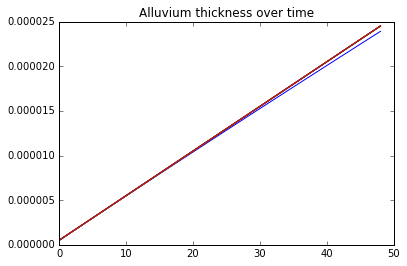

In [18]:
for i in range(num_time_steps):
    S = (z[upper] - z[1:]) / dx
    
    Es = Ks * q * S * (1.0 - np.exp(-H[upper] / Hstar))
    
    Er = Kr * q * S * np.exp(-H[upper] / Hstar)
    
    for j in range(num_nodes - 1):
        qs[j] = (((Es[j]) + (1-Ff) * Er[j]) / Voverq) * (1.0 - np.exp(-dx * Voverq)) + (qs_in[j] * np.exp(-dx * Voverq))
        qs_in[j+1] = qs[j]
    
    H[upper] += dt * ((qs[upper] * Voverq) - Ks * q * S *(1.0 - np.exp(-H[upper]/Hstar)))
    
    R[upper] += dt * (U - Kr * q * S * (np.exp(-H[upper] / Hstar)))
    
    if i % 5000 == 0:
        plt.plot(H[:-1])
        plt.title('Alluvium thickness over time')
    
    z = R + H

[  5.00249958e-07   1.00049967e-06   1.50074912e-06   2.00099833e-06
   2.50124729e-06   3.00149600e-06   3.50174445e-06   4.00199266e-06
   4.50224062e-06   5.00248832e-06   5.50273578e-06   6.00298298e-06
   6.50322994e-06   7.00347664e-06   7.50372310e-06   8.00396930e-06
   8.50421526e-06   9.00446096e-06   9.50470641e-06   1.00049516e-05
   1.05051966e-05   1.10054413e-05   1.15056857e-05   1.20059299e-05
   1.25061739e-05   1.30064176e-05   1.35066610e-05   1.40069042e-05
   1.45071472e-05   1.50073899e-05   1.55076323e-05   1.60078745e-05
   1.65081165e-05   1.70083582e-05   1.75085996e-05   1.80088408e-05
   1.85090818e-05   1.90093225e-05   1.95095629e-05   2.00098031e-05
   2.05100431e-05   2.10102828e-05   2.15105222e-05   2.20107614e-05
   2.25110004e-05   2.30112391e-05   2.35114775e-05   2.40117157e-05
   2.45119537e-05   0.00000000e+00]


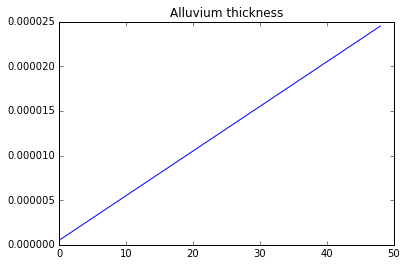

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(H[:-1])
plt.title('Alluvium thickness')
print H

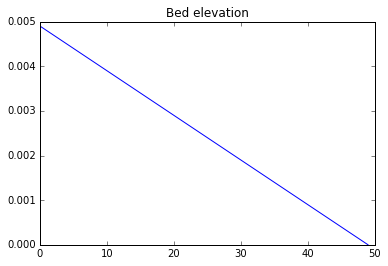

In [6]:
plt.plot(z)
plt.title('Bed elevation')

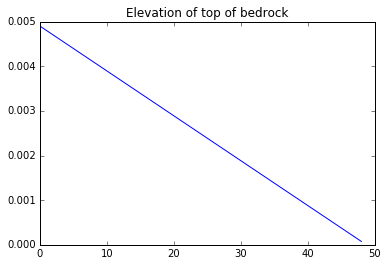

In [7]:
plt.plot(R[:-1])
plt.title('Elevation of top of bedrock')

Now, a version with 10-second time steps. We get the same values!

In [8]:
# reset variables, otherwise the code below uses H, z etc from previous run

num_nodes = 50
dx = 1.0
S0 = 0.01
q = 1.0 # In this version, discharge stays constant downstream
V = 0.001 # settling velocity
Ff = 0.5
Ks = 1.0 # sed erodibility. not necessarily realistic
Kr = 0.001
Hstar = 1.0 # sed thickness req'd for full entrainment potential. Not necessarily realistic.
Voverq = V/q # this can be a constant because q doesn't change downstream in this version
dt = 10.0 # seconds
total_time = 5000000.0
num_time_steps = int(total_time / dt)
U = 1.0e-7 # 1.0e-7 is still ~3m/year

# array index
upper = np.arange(num_nodes-1)

# arrays
qs = np.zeros(num_nodes)
qs_in = np.zeros(num_nodes)
x = dx * np.arange(0, num_nodes)
H = np.zeros(num_nodes)
R = np.zeros(num_nodes)
z = (S0 * (num_nodes - 1) * dx - S0 * x)
R[:] = z


for i in range(num_time_steps):
    S = (z[upper] - z[1:]) / dx
    
    Es = Ks * q * S * (1.0 - np.exp(-H[upper] / Hstar))
    
    Er = Kr * q * S * np.exp(-H[upper] / Hstar)
    
    for j in range(num_nodes - 1):
        qs[j] = (((Es[j]) + (1-Ff) * Er[j]) / Voverq) * (1.0 - np.exp(-dx * Voverq)) + (qs_in[j] * np.exp(-dx * Voverq))
        qs_in[j+1] = qs[j]
    
    H[upper] += dt * ((qs[upper] * Voverq) - Ks * q * S *(1.0 - np.exp(-H[upper]/Hstar)))
    
    R[upper] += dt * (U - Kr * q * S * (np.exp(-H[upper] / Hstar)))
    
    z = R + H 

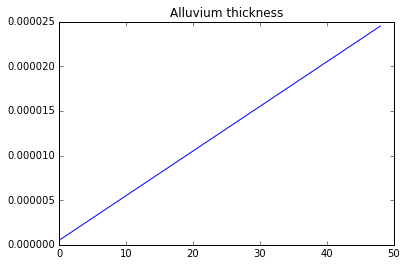

In [9]:
plt.plot(H[:-1])
plt.title('Alluvium thickness')

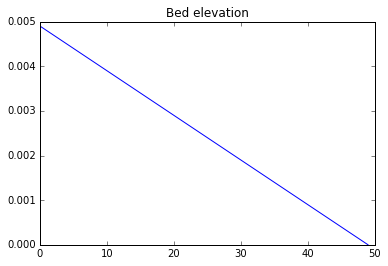

In [10]:
plt.plot(z)
plt.title('Bed elevation')

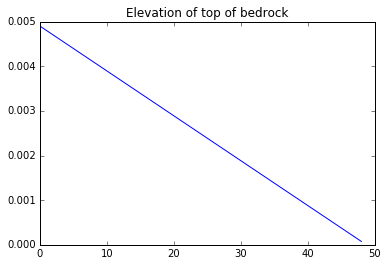

In [11]:
plt.plot(R[:-1])
plt.title('Elevation of top of bedrock')

Now a version with 1000-second time steps. This causes a bunch of overflows and errors.

In [13]:
# reset variables, otherwise the code below uses H, z etc from previous run

num_nodes = 50
dx = 1.0
S0 = 0.01
q = 1.0 # In this version, discharge stays constant downstream
V = 0.001 # settling velocity
Ff = 0.5
Ks = 1.0 # sed erodibility. not necessarily realistic
Kr = 0.001
Hstar = 1.0 # sed thickness req'd for full entrainment potential. Not necessarily realistic.
Voverq = V/q # this can be a constant because q doesn't change downstream in this version
dt = 1000.0 # seconds
total_time = 5000000.0
num_time_steps = int(total_time / dt)
U = 1.0e-7 # 1.0e-7 is still ~3m/year

# array index
upper = np.arange(num_nodes-1)

# arrays
qs = np.zeros(num_nodes)
qs_in = np.zeros(num_nodes)
x = dx * np.arange(0, num_nodes)
H = np.zeros(num_nodes)
R = np.zeros(num_nodes)
z = (S0 * (num_nodes - 1) * dx - S0 * x)
R[:] = z



for i in range(num_time_steps):
    S = (z[upper] - z[1:]) / dx
    
    Es = Ks * q * S * (1.0 - np.exp(-H[upper] / Hstar))
    
    Er = Kr * q * S * np.exp(-H[upper] / Hstar)
    
    for j in range(num_nodes - 1):
        qs[j] = (((Es[j]) + (1-Ff) * Er[j]) / Voverq) * (1.0 - np.exp(-dx * Voverq)) + (qs_in[j] * np.exp(-dx * Voverq))
        qs_in[j+1] = qs[j]
    
    H[upper] += dt * ((qs[upper] * Voverq) - Ks * q * S *(1.0 - np.exp(-H[upper]/Hstar)))
    
    R[upper] += dt * (U - Kr * q * S * (np.exp(-H[upper] / Hstar)))
    
    z = R + H 

/Users/Sarah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: overflow encountered in exp
/Users/Sarah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: overflow encountered in exp
/Users/Sarah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in exp
/Users/Sarah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/Users/Sarah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/Sarah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp
/Users/Sarah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in subtract


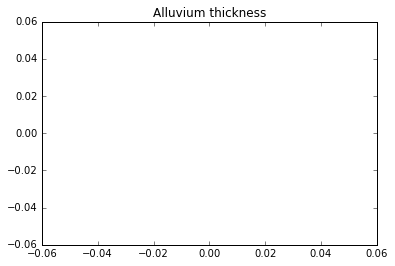

In [14]:
plt.plot(H[:-1])
plt.title('Alluvium thickness')

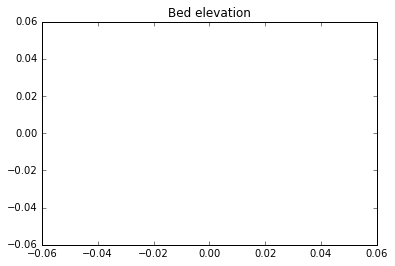

In [15]:
plt.plot(z[:-1])
plt.title('Bed elevation')

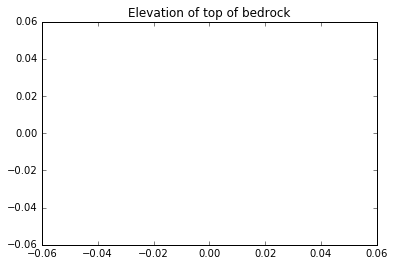

In [16]:
plt.plot(R[:-1])
plt.title('Elevation of top of bedrock')